In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import regex as re

In [3]:
!pip install transformers
!pip install torch

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/12/dd/f17b11a93a9ca27728e12512d167eb1281c151c4c6881d3ab59eb58f4127/transformers-4.35.2-py3-none-any.whl.metadata
  Using cached transformers-4.35.2-py3-none-any.whl.metadata (123 kB)
  Obtaining dependency information for huggingface-hub<1.0,>=0.16.4 from https://files.pythonhosted.org/packages/05/09/1945ca6ba3ad8ad6e2872ba682ce8d68c5e63c8e55458ed8ab4885709f1d/huggingface_hub-0.19.4-py3-none-any.whl.metadata
  Using cached huggingface_hub-0.19.4-py3-none-any.whl.metadata (14 kB)
  Obtaining dependency information for tokenizers<0.19,>=0.14 from https://files.pythonhosted.org/packages/eb/3d/eee5f3c572a3f4db2ebabf5bd4f284f356078a5b5d27e6229b4450d5c5e4/tokenizers-0.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached tokenizers-0.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Obtaining dependency information for safetensor

In [6]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.3.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [7]:
import transformers
import torch
print(torch.__version__)

2.1.1+cu121


In [8]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-53b4b48f-cdd3-47b0-8e67-51d389b90322;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 292ms :: artifacts dl 18ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

23/11/30 00:06:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


3.3.0


In [9]:
cwd = os.getcwd()
print(cwd)

/root/fall-2023-reddit-project-team-17/code/project-ml


In [10]:
!aws s3 ls s3://project17-bucket-alex

                           PRE books/
                           PRE covid-no-stupid-questions.parquet/
                           PRE flairs/
                           PRE lab8/
                           PRE matt-age-gender-sentiment/
                           PRE matt-comment-subreddit-counts/
                           PRE matt-submission-subreddit-counts/
                           PRE matt-submissions-age-gender/
                           PRE matt-submissions-cv/
                           PRE project_2022/
                           PRE project_2022_1/
                           PRE project_2022_10/
                           PRE project_2022_11/
                           PRE project_2022_12/
                           PRE project_2022_2/
                           PRE project_2022_3/
                           PRE project_2022_4/
                           PRE project_2022_5/
                           PRE project_2022_6/
                           PRE project_2022_7/
     

In [11]:
%%time
# Read in data from project bucket
bucket = "project17-bucket-alex"

path = f"s3a://{bucket}/covid-no-stupid-questions.parquet"

df = spark.read.parquet(path, header = True)

23/11/30 00:06:24 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


CPU times: user 3.73 ms, sys: 4.75 ms, total: 8.48 ms
Wall time: 5.94 s


In [12]:
%%time
df.show(5)

+--------------------+--------------+----------------------+-----------------+--------------------+--------+----------------+-------------------+-------------+------+------+-------+------------+---------+----------+--------------------+-------------------+-----+--------+-----------------+------------+--------------------+--------------------+
|              author|author_cakeday|author_flair_css_class|author_flair_text|                body|can_gild|controversiality|        created_utc|distinguished|edited|gilded|     id|is_submitter|  link_id| parent_id|           permalink|       retrieved_on|score|stickied|        subreddit|subreddit_id|               words|      filtered_words|
+--------------------+--------------+----------------------+-----------------+--------------------+--------+----------------+-------------------+-------------+------+------+-------+------------+---------+----------+--------------------+-------------------+-----+--------+-----------------+------------+--------

In [ ]:
# quick note, I got a bit ahead of myself and already used spark.ml to tokenize and remove stopwords in the NLP portion of my work, but it should probably be in the ml section. 

In [13]:
print(df.count())
df.printSchema()

31275
root
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: 

In [14]:
from pyspark.sql.functions import size
df_filtered = df.filter(size(df.filtered_words) > 50)

In [15]:
df_filtered.count()
df_filtered.show(5)

+-------------------+--------------+----------------------+-----------------+--------------------+--------+----------------+-------------------+-------------+------+------+-------+------------+---------+----------+--------------------+-------------------+-----+--------+-----------------+------------+--------------------+--------------------+
|             author|author_cakeday|author_flair_css_class|author_flair_text|                body|can_gild|controversiality|        created_utc|distinguished|edited|gilded|     id|is_submitter|  link_id| parent_id|           permalink|       retrieved_on|score|stickied|        subreddit|subreddit_id|               words|      filtered_words|
+-------------------+--------------+----------------------+-----------------+--------------------+--------+----------------+-------------------+-------------+------+------+-------+------------+---------+----------+--------------------+-------------------+-----+--------+-----------------+------------+-----------

In [16]:
df_filtered.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array 

In [23]:
from pyspark.sql.functions import month, dayofmonth, year

#for eac uniqu month create 2 new df
unique_months_years = df_filtered.select(month("created_utc").alias("month"), year("created_utc").alias("year")).distinct().collect()

dfs = {}

for row in unique_months_years:
    mth, yr = row['month'], row['year']
    
    df_first_half = df_filtered.filter((month(df_filtered.created_utc) == mth) & (dayofmonth(df_filtered.created_utc) <= 15) & (year(df_filtered.created_utc) == yr))
    df_second_half = df_filtered.filter((month(df_filtered.created_utc) == mth) & (dayofmonth(df_filtered.created_utc) > 15) & (year(df_filtered.created_utc) == yr))

    dfs[f"df_{yr}_{mth:02d}_1st"] = df_first_half
    dfs[f"df_{yr}_{mth:02d}_2nd"] = df_second_half


In [24]:
print(len(dfs))
dfs

24


{'df_2022_01_1st': DataFrame[author: string, author_cakeday: boolean, author_flair_css_class: string, author_flair_text: string, body: string, can_gild: boolean, controversiality: bigint, created_utc: timestamp, distinguished: string, edited: string, gilded: bigint, id: string, is_submitter: boolean, link_id: string, parent_id: string, permalink: string, retrieved_on: timestamp, score: bigint, stickied: boolean, subreddit: string, subreddit_id: string, words: array<string>, filtered_words: array<string>],
 'df_2022_01_2nd': DataFrame[author: string, author_cakeday: boolean, author_flair_css_class: string, author_flair_text: string, body: string, can_gild: boolean, controversiality: bigint, created_utc: timestamp, distinguished: string, edited: string, gilded: bigint, id: string, is_submitter: boolean, link_id: string, parent_id: string, permalink: string, retrieved_on: timestamp, score: bigint, stickied: boolean, subreddit: string, subreddit_id: string, words: array<string>, filtered_w

In [25]:
from pyspark.sql.functions import desc

for key, df in dfs.items():
    dfs[key] = df.orderBy(desc("score"))

In [26]:
key_1, df_1 = next(iter(dfs.items()))

df_1.show(5)

+----------------+--------------+----------------------+-----------------+--------------------+--------+----------------+-------------------+-------------+-------------+------+-------+------------+---------+----------+--------------------+-------------------+-----+--------+-----------------+------------+--------------------+--------------------+
|          author|author_cakeday|author_flair_css_class|author_flair_text|                body|can_gild|controversiality|        created_utc|distinguished|       edited|gilded|     id|is_submitter|  link_id| parent_id|           permalink|       retrieved_on|score|stickied|        subreddit|subreddit_id|               words|      filtered_words|
+----------------+--------------+----------------------+-----------------+--------------------+--------+----------------+-------------------+-------------+-------------+------+-------+------------+---------+----------+--------------------+-------------------+-----+--------+-----------------+------------

In [27]:
# base = "../../data/ml-data/nsq/"

# for df_name, df in dfs.items():
#     path = f"{base}{df_name}.parquet"
#     df.write.parquet(path)

In [28]:
#print the length of each df
for df_name, df in dfs.items():
    my_count = df.count()
    print(f'{df_name} has {my_count} rows')

df_2022_01_1st has 1231 rows


df_2022_01_2nd has 865 rows


df_2022_09_1st has 309 rows


df_2022_09_2nd has 468 rows


df_2022_04_1st has 343 rows


df_2022_04_2nd has 552 rows


df_2022_10_1st has 308 rows


df_2022_10_2nd has 524 rows


df_2022_12_1st has 379 rows


df_2022_12_2nd has 864 rows


df_2022_11_1st has 383 rows


df_2022_11_2nd has 516 rows


df_2022_03_1st has 462 rows


df_2022_03_2nd has 365 rows


df_2022_06_1st has 435 rows


df_2022_06_2nd has 310 rows


df_2022_05_1st has 286 rows


df_2022_05_2nd has 300 rows


df_2022_02_1st has 814 rows


df_2022_02_2nd has 405 rows


df_2022_08_1st has 248 rows


df_2022_08_2nd has 382 rows


df_2022_07_1st has 311 rows


df_2022_07_2nd has 292 rows


In [30]:
#saved my work and stopped here so I'm reloading the data
base = "../../data/ml-data/nsq/"

dirs = [d for d in os.listdir(base) if d.endswith('.parquet')]

dfs = {}

for p in dirs:
    path = os.path.join(base, p)
    df_name = p.split('.')[0]
    dfs[df_name] = spark.read.parquet(path)

In [53]:
dfs['df_2022_12_1st']

TypeError: 'Column' object is not callable

In [33]:
from transformers import pipeline, BartTokenizer

# Init
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

max_tokens = 512  # Reduced max tokens

summaries = {}

for df_name, df in dfs.items():
    first_body = df.select("body").first()["body"]
    
    # Check for empty text
    if not first_body:
        summaries[df_name] = "Empty body text"
        continue

    # Truncate the text more aggressively
    tokens = tokenizer(first_body, truncation=True, max_length=max_tokens, return_tensors="pt")["input_ids"]
    truncated_text = tokenizer.decode(tokens[0])

    # Summarize the truncated text
    summary = summarizer(truncated_text, max_length=130, min_length=100, do_sample=False)[0]['summary_text']
    summaries[df_name] = summary

Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)
Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


In [54]:
test1_body = next(iter(dfs))

print(test1_body)

df_2022_12_1st


In [34]:
test1 = next(iter(summaries))

print(f"{test1}: \n {summaries[test1]}")

df_2022_12_1st: 
 Carlin has drawn attention for a routine from his 1999 special, “You Are All Diseased.” He mischievously suggests that a childhood spent swimming in the polluted Hudson River was the reason he didn’t catch polio. Some viewers concluded — wrongly — that her father would have opposed coronavirus vaccines. “Everyone’s like, see? George Carlin would have been anti-vaccination,” she said. ‘I’m like, no. My dad was pro-science,. pro-rational thinking, pro-evidence-based medicine. The man was a heart


In [56]:
test1_key = dfs[test1]

test1_body_txt = test1_key.select("body").first()["body"]

print(test1_body_txt)

I can understand that frustration and getting tired of the cynicism or generation of toxic beliefs, but it should be noted that about that bit from his 1999 special about the immune system and all that, his family [has outright said](https://www.nytimes.com/2022/05/11/arts/george-carlin-comedy.html):

&gt; Several times during the pandemic, Carlin has drawn attention for a routine from his 1999 special, “You Are All Diseased,” in which he mischievously suggests that a childhood spent swimming in the polluted Hudson River was the reason he didn’t catch polio.
&gt; 
&gt; (“In my neighborhood, no one ever got polio,” he fulminates. “*No one*, **ever**. You know why? ’Cause *we swam in raw sewage*. It *strengthened our immune systems*. The polio never had a prayer.”)
&gt; 
&gt; As Kelly Carlin explained, some viewers concluded — wrongly — that her father would have opposed coronavirus vaccines.
&gt; 
&gt; “Everyone’s like, see? George Carlin would have been anti-vaccination,” she said. “An

In [36]:
import random
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from transformers import BertTokenizer, BertForSequenceClassification

# Initialize the FinBERT model and tokenizer
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

#function to get sentiment
def apply_sentiment_analysis(text):
    try:
        result = nlp(text)
        return str(result[0]['label'])
    except Exception as e:
        return str(e)

apply_sentiment_analysis_udf = udf(apply_sentiment_analysis, StringType())

sentiment_results = {}

# Iterate over each df
for df_name, df in dfs.items():
    # Sample 
    sampled_df = df.sample(fraction=0.25)

    # Perform sentiment analysis 
    sentiment_df = sampled_df.withColumn("sentiment", apply_sentiment_analysis_udf(sampled_df["body"]))
    sentiment_results[df_name] = sentiment_df

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [39]:
first_key = next(iter(sentiment_results))

first_sentiment_df = sentiment_results[first_key]

first_sentiment_df.select("sentiment").show()

+--------------------+
|           sentiment|
+--------------------+
|            Negative|
|             Neutral|
|             Neutral|
|            Positive|
|             Neutral|
|             Neutral|
|             Neutral|
|             Neutral|
|             Neutral|
|             Neutral|
|             Neutral|
|             Neutral|
|             Neutral|
|             Neutral|
|The size of tenso...|
|            Positive|
|             Neutral|
|             Neutral|
|             Neutral|
|             Neutral|
+--------------------+
only showing top 20 rows



In [68]:
distinct_sentiments = first_sentiment_df.select("sentiment").distinct()

sentiment_counts_df = (first_sentiment_df.filter(col("sentiment").isin(valid_sentiments))
                              .groupBy("sentiment")
                              .count()
                              .orderBy("sentiment"))

sentiment_counts_pd = sentiment_counts_df.toPandas()

output_directory = "../../website-source/img/ml-plots"

output_filename = os.path.join(output_directory, "sentiment_analysis_plot.png")

plt.savefig(output_filename, format='png')

sentiment_counts_pd

,sentiment,count
0,Negative,8
1,Neutral,60
2,Positive,4


<Figure size 640x480 with 0 Axes>

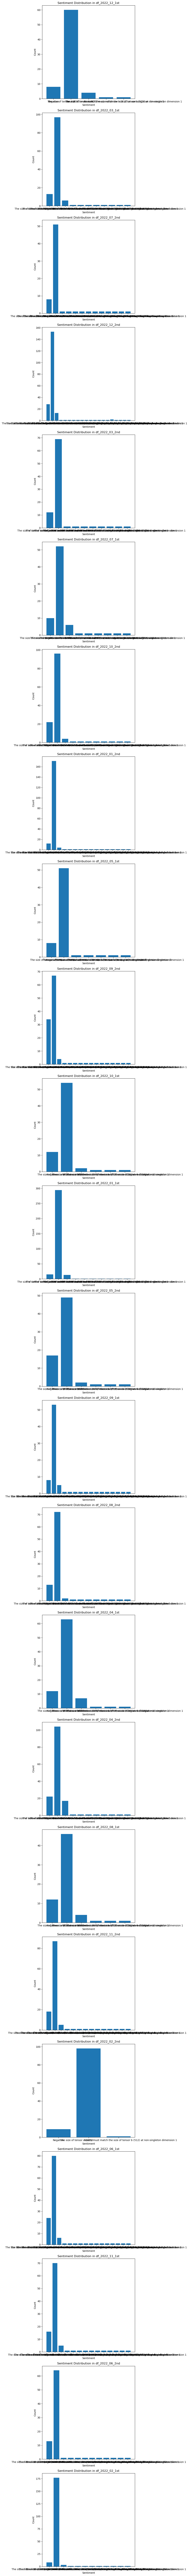

In [60]:
from pyspark.sql.functions import col

sentiment_counts = {}

for df_name, df in sentiment_results.items():
    counts = df.groupBy("sentiment").count().orderBy("sentiment")
    sentiment_counts[df_name] = counts.toPandas()
    
num_dfs = len(sentiment_counts)

fig, axes = plt.subplots(num_dfs, 1, figsize=(10, 6 * num_dfs))

if num_dfs == 1:
    axes = [axes]

for ax, (df_name, sentiment_df) in zip(axes, sentiment_counts.items()):
    ax.bar(sentiment_df['sentiment'], sentiment_df['count'])
    ax.set_title(f"Sentiment Distribution in {df_name}")
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Count')
    ax.set_xticks(sentiment_df['sentiment'])
    ax.set_xticklabels(sentiment_df['sentiment'])

plt.tight_layout()
plt.show()